<a href="https://colab.research.google.com/github/drewwint/neuromatch-2021/blob/main/tutorials/W3D5_NetworkCausality/student/W3D5_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4: Instrumental Variables
**Week 3, Day 5: Network Causality**

**By Neuromatch Academy**

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content reviewers**: Mike X Cohen, Madineh Sarvestani, Yoni Friedman, Ella Batty, Michael Waskom

---
# Tutorial objectives

*Estimated timing of tutorial: 1 hour, 5 min*

This is our final tutorial on our day of examining causality. Below is the high level outline of what we've covered today, with the sections we will focus on in this notebook in bold:

1.   Master definitions of causality
2.   Understand that estimating causality is possible
3.   Learn 4 different methods and understand when they fail
    1. perturbations
    2. correlations
    3. simultaneous fitting/regression
    4. **instrumental variables**

### Notebook 4 Objectives

In tutorial 3 we saw that even more sophisticated techniques such as simultaneous fitting fail to capture causality in the presence of omitted variable bias. So what techniques are there for us to obtain valid causal measurements when we can't perturb the system? Here we will:

- learn about **instrumental variables,** a method that does not require experimental data for valid causal analysis
- explore benefits of instrumental variable analysis and limitations
    - addresses **omitted variable bias** seen in regression
    - less efficient in terms of sample size than other techniques
    - requires a particular form of randomness in the system in order for causal effects to be identified

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/gp4m9/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Lasso

In [2]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n,endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k',s=150)
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i, j], head_width=.15,
                        width = A[i,j] / 25, shape='right', length_includes_head=True)
    ax.axis('off')

def plot_neural_activity(X):
  """Plot first 10 timesteps of neural activity

  Args:
    X (ndarray): neural activity (n_neurons by timesteps)

  """
  f, ax = plt.subplots()
  im = ax.imshow(X[:, :10], aspect='auto')
  divider = make_axes_locatable(ax)
  cax1 = divider.append_axes("right", size="5%", pad=0.15)
  plt.colorbar(im, cax=cax1)
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')


def compare_granger_connectivity(A, reject_null, selected_neuron):
  """Plot granger connectivity vs true

  Args:
    A (ndarray): true connectivity (n_neurons by n_neurons)
    reject_null (list): outcome of granger causality, length n_neurons
    selecte_neuron (int): the neuron we are plotting connectivity from

  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  im = axs[0].imshow(A[:, [selected_neuron]], cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax = axs[0])
  axs[0].set_xticks([0])
  axs[0].set_xticklabels([selected_neuron])
  axs[0].title.set_text("True connectivity for neuron {}".format(selected_neuron))

  im = axs[1].imshow(np.array([reject_null]).transpose(), cmap='coolwarm', aspect='auto')
  plt.colorbar(im, ax=axs[1])
  axs[1].set_xticks([0])
  axs[1].set_xticklabels([selected_neuron])
  axs[1].title.set_text("Granger causality connectivity for neuron {}".format(selected_neuron))


def plot_performance_vs_eta(etas, corr_data):
  """ Plot IV estimation performance as a function of instrument strength

    Args:
      etas (list): list of instrument strengths
      corr_data (ndarray): n_trials x len(etas) array where each element is the correlation
        between true and estimated connectivity matries for that trial and
        instrument strength

  """
  corr_mean = corr_data.mean(axis=0)
  corr_std = corr_data.std(axis=0)

  plt.plot(etas, corr_mean)
  plt.fill_between(etas,
              corr_mean - corr_std,
              corr_mean + corr_std,
              alpha=.2)
  plt.xlim([etas[0], etas[-1]])
  plt.title("IV performance as a function of instrument strength")
  plt.ylabel("Correlation b.t. IV and true connectivity")
  plt.xlabel("Strength of instrument (eta)")
  plt.show()

In [4]:
# @title Helper Functions

def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))


def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
  """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R


def print_corr(v1, v2, corrs, idx_dict):
    """Helper function for formatting print statements for correlations"""
    text_dict = {'Z':'taxes', 'T':'# cigarettes', 'C':'SES status', 'Y':'birth weight'}
    print("Correlation between {} and {} ({} and {}): {:.3f}".format(v1, v2, text_dict[v1], text_dict[v2], corrs[idx_dict[v1], idx_dict[v2]]))


def get_regression_estimate(X, neuron_idx=None):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    if neuron_idx is None:
        Y = X[:, 1:].transpose()
    else:
        Y = X[[neuron_idx], 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    regression = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01), n_jobs=-1)

    regression.fit(W,Y)

    if neuron_idx is None:
        V = np.zeros((n_neurons, n_neurons))
        for i, estimator in enumerate(regression.estimators_):
            V[i, :] = estimator.coef_
    else:
        V = regression.estimators_[0].coef_

    return V


def get_regression_corr(n_neurons, timesteps, random_state, observed_ratio, regression_args, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate(sel_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1, 0]
    else:
        return np.corrcoef(sel_A[neuron_idx, :], sel_V)[1, 0]


def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False, alpha=0.01, max_iter=200), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V


The helper functions defined above are:
- `sigmoid`: computes sigmoid nonlinearity element-wise on input, from Tutorial 1
- `logit`: applies the logit (inverse sigmoid) transformation, from Tutorial 3
- `create_connectivity`: generates nxn causal connectivity matrix., from Tutorial 1
- `simulate_neurons`: simulates a dynamical system for the specified number of neurons and timesteps, from Tutorial 1
- `get_sys_corr`: a wrapper function for correlation calculations between A and R, from Tutorial 2
- `correlation_for_all_neurons`: computes the connectivity matrix for the all neurons using correlations, from Tutorial 2
- `print_corr`: formats print statements for correlations
- `get_regression_estimate`: estimates the connectivity matrix using lasso regression, from Tutorial 3
- `get_regression_corr`: a wrapper function for our correlation calculations between A and the V estimated from regression.
- `get_regression_estimate_full_connectivity`: estimates the connectivity matrix using lasso regression, from Tutorial 3
- `get_regression_corr_full_connectivity`: a wrapper function for our correlation calculations between A and the V estimated from regression, from Tutorial 3



---
# Section 1: Instrumental Variables

In [ ]:
# @title Video 1: Instrumental Variables
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1of4y1R7L1", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="0gkav6BS4-w", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

If there is randomness naturally occurring in the system *that we can observe*, this in effect becomes the perturbations we can use to recover causal effects. This is called an **instrumental variable**. At high level, an instrumental variable must


1.   be observable
2.   effect a covariate you care about
3.   **not** effect the outcome, except through the covariate


It's rare to find these things in the wild, but when you do it's very powerful. 






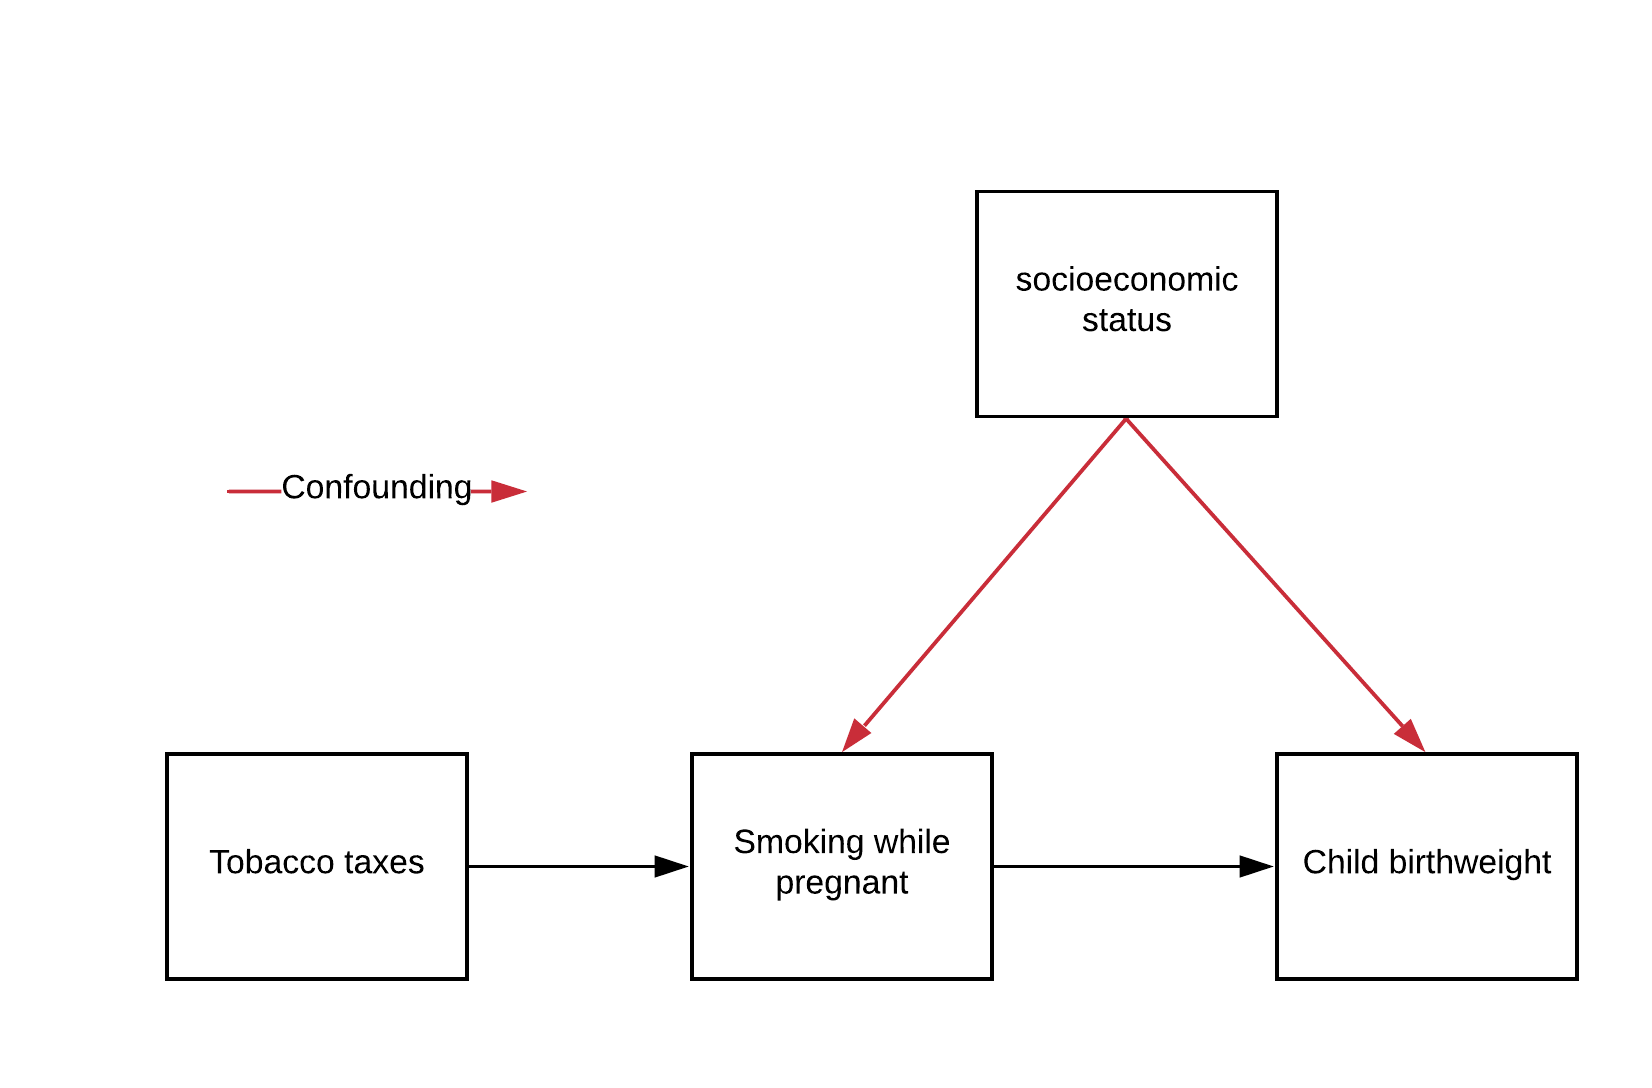


## Section 1.1: A non-neuro example of an IV
A classic example is estimating the effect of smoking cigarettes while pregnant on the birth weight of the infant. There is a (negative) correlation, but is it causal? Unfortunately many confounds affect both birth weight and smoking. Wealth is a big one.

Instead of controlling for everything imaginable, one can find an IV. Here the instrumental variable is **state taxes on tobacco**. These


1.   Are observable
2.   Affect tobacco consumption
3.   Don't affect birth weight except through tobacco

By using the power of IV techniques, you can determine the causal effect without exhaustively controlling for everything.


Let's represent our tobacco example above with the following notation:

- $Z_{\text{taxes}}$: our tobacco tax **instrument**, which only affects an individual's tendency to smoke while pregnant within our system
- $T_{\text{smoking}}$: number of cigarettes smoked per day while pregnant, our "treatment" if this were a randomized trial
- $C_{\text{SES}}$: socioeconomic status (higher means weathier), a **confounder** if it is not observed
- $Y_{\text{birthweight}}$: child birthweight in grams, our outcome of interest

Let's suppose we have the following function for our system:

$Y_{\text{birthweight}} = 3000 + C_{\text{SES}} - 2T_{\text{smoking}},$

with the additional fact that $C_{\text{SES}}$ is negatively correlated with $T_{\text{smoking}}$. 

The causal effect we wish to estimate is the coefficient $-2$ for $T_{\text{smoking}}$, which means that if a mother smokes one additional cigarette per day while pregnant her baby will be 2 grams lighter at birth.

We've provided a covariance matrix with the desired structure in the code cell below, so please run it to look at the correlations between our variables.

In [5]:
# @markdown Execute this cell to see correlations with C
# run this code below to generate our setup
idx_dict = {
    'Z': 0,
    'T': 1,
    'C': 2,
    'Y': 3
}
# vars:             Z    T    C
covar = np.array([[1.0, 0.5, 0.0],  # Z
                  [0.5, 1.0, -0.5],  # T
                  [0.0, -0.5, 1.0]])  # C
# vars:  Z  T  C
means = [0, 5, 2]

# generate some data
np.random.seed(42)
data = np.random.multivariate_normal(mean=means, cov=2 * covar, size=2000)

# generate Y from our equation above
Y = 3000 + data[:, idx_dict['C']] - (2 * (data[:, idx_dict['T']]))

data = np.concatenate([data, Y.reshape(-1, 1)], axis=1)

Z = data[:, [idx_dict['Z']]]
T = data[:, [idx_dict['T']]]
C = data[:, [idx_dict['C']]]
Y = data[:, [idx_dict['Y']]]

corrs = np.corrcoef(data.transpose())

print_corr('C', 'T', corrs, idx_dict)
print_corr('C', 'Y', corrs, idx_dict)

Correlation between C and T (SES status and # cigarettes): -0.483
Correlation between C and Y (SES status and birth weight): 0.740


We see what is exactly represented in our graph above: $C_{\text{SES}}$ is correlated with both $T_{\text{smoking}}$ and $Y_{\text{birthweight}}$, so $C_{\text{SES}}$ is a potential confounder if not included in our analysis. Let's say that it is difficult to observe and quantify $C_{\text{SES}}$, so we do not have it available to regress against. This is another example of the **omitted variable bias** we saw in the last tutorial.

What about $Z_{\text{taxes}}$? Does it satisfy conditions 1, 2, and 3 of an instrument?

In [6]:
#@markdown Execute this cell to see correlations of Z
print("Condition 2?")
print_corr('Z', 'T', corrs, idx_dict)
print("Condition 3?")
print_corr('Z', 'C', corrs, idx_dict)

Condition 2?
Correlation between Z and T (taxes and # cigarettes): 0.519
Condition 3?
Correlation between Z and C (taxes and SES status): 0.009


Perfect! We see that $Z_{\text{taxes}}$ is correlated with $T_{\text{smoking}}$ (#2) but is uncorrelated with $C_{\text{SES}}$ (#3).  $Z_\text{taxes}$ is also observable (#1), so we've satisfied our three criteria for an instrument:

1.   $Z_\text{taxes}$ is observable
2.   $Z_\text{taxes}$ affects $T_{\text{smoking}}$
3.   $Z_\text{taxes}$ doesn't affect $Y_{\text{birthweight}}$ except through $T_{\text{smoking}}$ (ie $Z_\text{taxes}$ doesn't affect or is affected by $C_\text{SES}$)

## Section 1.2: How IV works, at high level

The easiest way to imagine IV is that the instrument is **an observable source of "randomness"** that affects the treatment. In this way it's similar to the interventions we talked about in Tutorial 1.

But how do you actually use the instrument? The key is that we need to extract **the component of the treatment that is due only to the effect of the instrument**. We will call this component $\hat{T}$.
$$
\hat{T}\leftarrow \text{The unconfounded component of }T
$$
Getting $\hat{T}$ is fairly simple. It is simply the predicted value of $T$ found in a regression that has only the instrument $Z$ as input.

Once we have the unconfounded component in hand, getting the causal effect is as easy as regressing the outcome on $\hat{T}$.

## Section 1.3: IV estimation using two-stage least squares

The fundamental technique for instrumental variable estimation is **two-stage least squares**. 

We run two regressions:

1. The first stage gets  $\hat{T}_{\text{smoking}}$ by regressing $T_{\text{smoking}}$ on $Z_\text{taxes}$, fitting the parameter $\hat{\alpha}$:

$$
\hat{T}_{\text{smoking}} = \hat{\alpha} Z_\text{taxes}
$$

2. The second stage then regresses $Y_{\text{birthweight}}$ on $\hat{T}_{\text{smoking}}$ to obtain an estimate $\hat{\beta}$ of the causal effect:

$$
\hat{Y}_{\text{birthweight}} = \hat{\beta} \hat{T}_{\text{smoking}} 
$$

The first stage estimates the **unconfounded component** of $T_{\text{smoking}}$ (ie, unaffected by the confounder $C_{\text{SES}}$), as we discussed above. 

Then, the second stage uses this unconfounded component $\hat{T}_{\text{smoking}}$ to estimate the effect of smoking on $\hat{Y}_{\text{birthweight}}$. 

We will explore how all this works in the next two exercises.


### Section 1.3.1: Least squares regression stage 1

In [ ]:
# @title Video 2: Stage 1
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1jK4y1x7q5", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="4WT0KrySRTg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

#### Coding Exercise 1.3.1: Compute regression stage 1

Let's run the regression of $T_{\text{smoking}}$ on $Z_\text{taxes}$ to compute $\hat{T}_{\text{smoking}}$. We will then check whether our estimate is still confounded with $C_{\text{SES}}$ by comparing the correlation of $C_{\text{SES}}$  with $T_{\text{smoking}}$ vs $\hat{T}_{\text{smoking}}$.

### Suggestions

- use the `LinearRegression()` model, already imported from scikit-learn
    - use `fit_intercept=True` as the only parameter setting
- be sure to check the ordering of the parameters passed to `LinearRegression.fit()`

In [8]:
def fit_first_stage(T, Z):
    """
    Estimates T_hat as the first stage of a two-stage least squares.

    Args:
        T (np.ndarray): our observed, possibly confounded, treatment of shape (n, 1)
        Z (np.ndarray): our observed instruments of shape (n, 1)

    Returns
        T_hat (np.ndarray): our estimate of the unconfounded portion of T
    """

    ############################################################################
    ## Insert your code here to fit the first stage of the 2-stage least squares
    ## estimate.
    ## Fill out function and remove
    ##raise NotImplementedError('Please complete fit_first_stage function')
    ############################################################################

    # Initialize linear regression model
    stage1 = LinearRegression(fit_intercept=True)

    # Fit linear regression model
    stage1.fit(Z, T)

    # Predict T_hat using linear regression model
    T_hat = stage1.predict(Z)

    return T_hat


# Estimate T_hat
T_hat = fit_first_stage(T, Z)

# Get correlations
T_C_corr = np.corrcoef(T.transpose(), C.transpose())[0, 1]
T_hat_C_corr = np.corrcoef(T_hat.transpose(), C.transpose())[0, 1]

# Print correlations
print("Correlation between T and C: {:.3f}".format(T_C_corr))
print("Correlation between T_hat and C: {:.3f}".format(T_hat_C_corr))

Correlation between T and C: -0.483
Correlation between T_hat and C: 0.009


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial4_Solution_009bc559.py)



You should see a correlation between $T$ and $C$ of `-0.483` and between $\hat{T}$ and $C$ of `0.009`.

### Section 1.3.2: Least squares regression stage 2

In [ ]:
# @title Video 3: Stage 2
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Kv411q7Wx", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="F-_m_Vgv75I", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

#### Coding Exercise 1.3.2: Compute the IV estimate

Now let's implement the second stage! Complete the `fit_second_stage()` function below. We will again use a linear regression model with an intercept. We will then use the function from Exercise 1 (`fit_first_stage`) and this function to estimate the full two-stage regression model. We will obtain the estimated causal effect of the number of cigarettes ($T$) on birth weight ($Y$).



In [10]:
def fit_second_stage(T_hat, Y):
    """
    Estimates a scalar causal effect from 2-stage least squares regression using
    an instrument.

    Args:
        T_hat (np.ndarray): the output of the first stage regression
        Y (np.ndarray): our observed response (n, 1)

    Returns:
        beta (float): the estimated causal effect
    """
    ############################################################################
    ## Insert your code here to fit the second stage of the 2-stage least squares
    ## estimate.
    ## Fill out function and remove
    ## raise NotImplementedError('Please complete fit_second_stage function')
    ############################################################################

    # Initialize linear regression model
    stage2 = LinearRegression(fit_intercept=True)

    # Fit model to data
    stage2.fit(T_hat, Y)

    return stage2.coef_


# Fit first stage
T_hat = fit_first_stage(T, Z)

# Fit second stage
beta = fit_second_stage(T_hat, Y)

# Print
print("Estimated causal effect is: {:.3f}".format(beta[0, 0]))

Estimated causal effect is: -1.984


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial4_Solution_6b49df33.py)



You should obtain an estimated causal effect of `-1.984`. This is quite close to the true causal effect of $-2$!

---
# Section 2: IVs in our simulated neural system

*Estimated timing to here from start of tutorial: 30 min*



In [ ]:
# @title Video 4: IVs in simulated neural systems
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1nA411v7Hs", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="b6a3Mrefk44", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Now, say we have the neural system we have been simulating, except with an additional variable $\vec{z}$. This will be our instrumental variable. 

We treat $\vec{z}$ as a source of noise in the dynamics of our neurons:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \eta \vec{z}_{t+1} + \epsilon_t)
$$

- $\eta$ is what we'll call the "strength" of our IV
- $\vec{z}_t$ is a random binary variable, $\vec{z}_t \sim Bernoulli(0.5)$

Remember that for each neuron $i$, we are trying to figure out whether $i$ is connected to (causally affects) the other neurons in our system *at the next time step*. So for timestep $t$, we want to determine whether $\vec{x}_{i,t}$ affects all the other neurons at $\vec{x}_{t+1}$. For a given neuron $i$, $\vec{z}_{i,t}$ satistfies the 3 criteria for a valid instrument. 


**What could $z$ be, biologically?**

Imagine $z$ to be some injected current through an *in vivo* patch clamp. It affects each neuron individually, and only affects dynamics through that neuron.

The cool thing about IV is that you don't have to control $z$ yourself - it can be observed. So if you mess up your wiring and accidentally connect the injected voltage to an AM radio, no worries. As long as you can observe the signal the method will work.

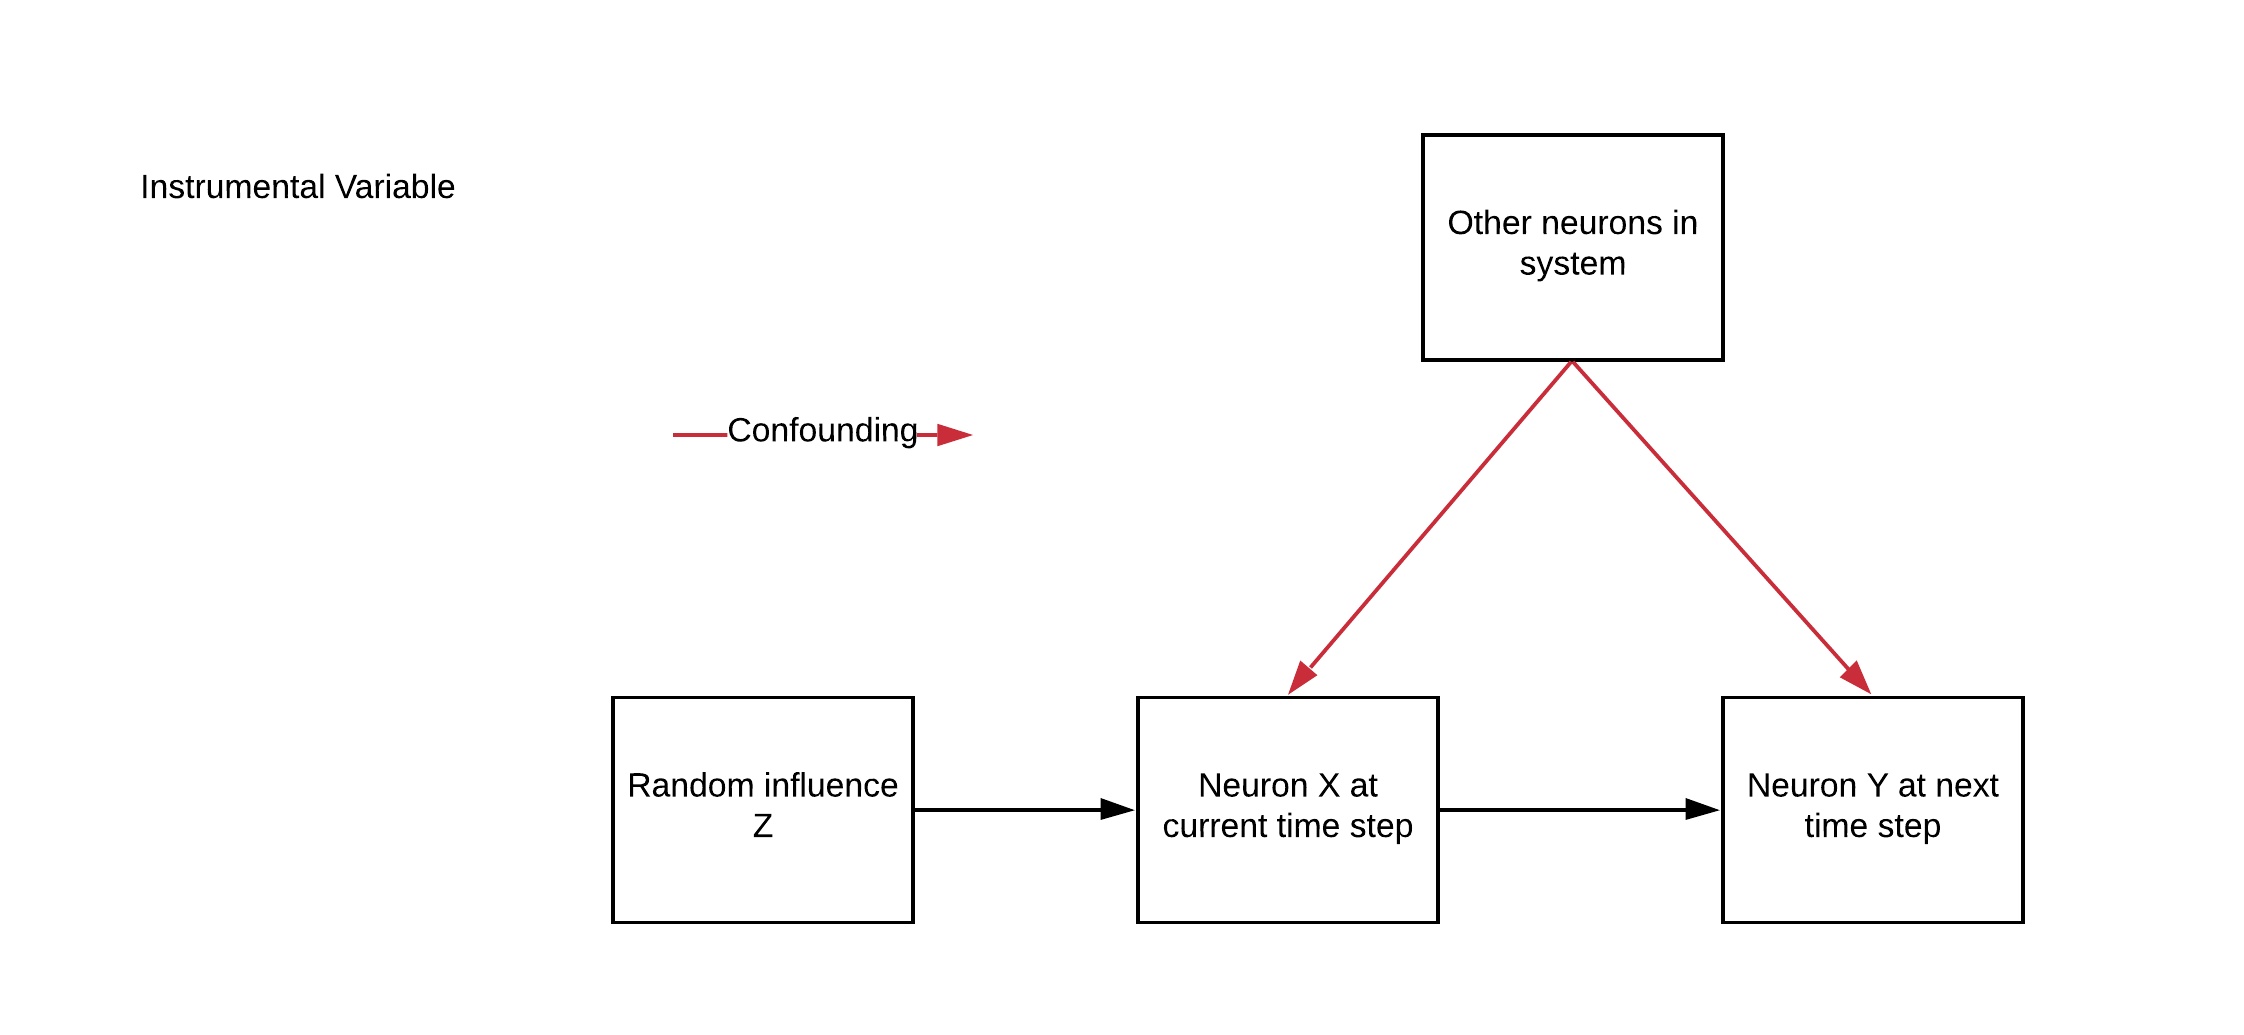

## Section 2.1: Simulate a system with IV

### Coding Exercise 2.1: Simulate a system with IV

Here we'll modify the function that simulates the neural system, but this time make the update rule include the effect of the instrumental variable $z$.

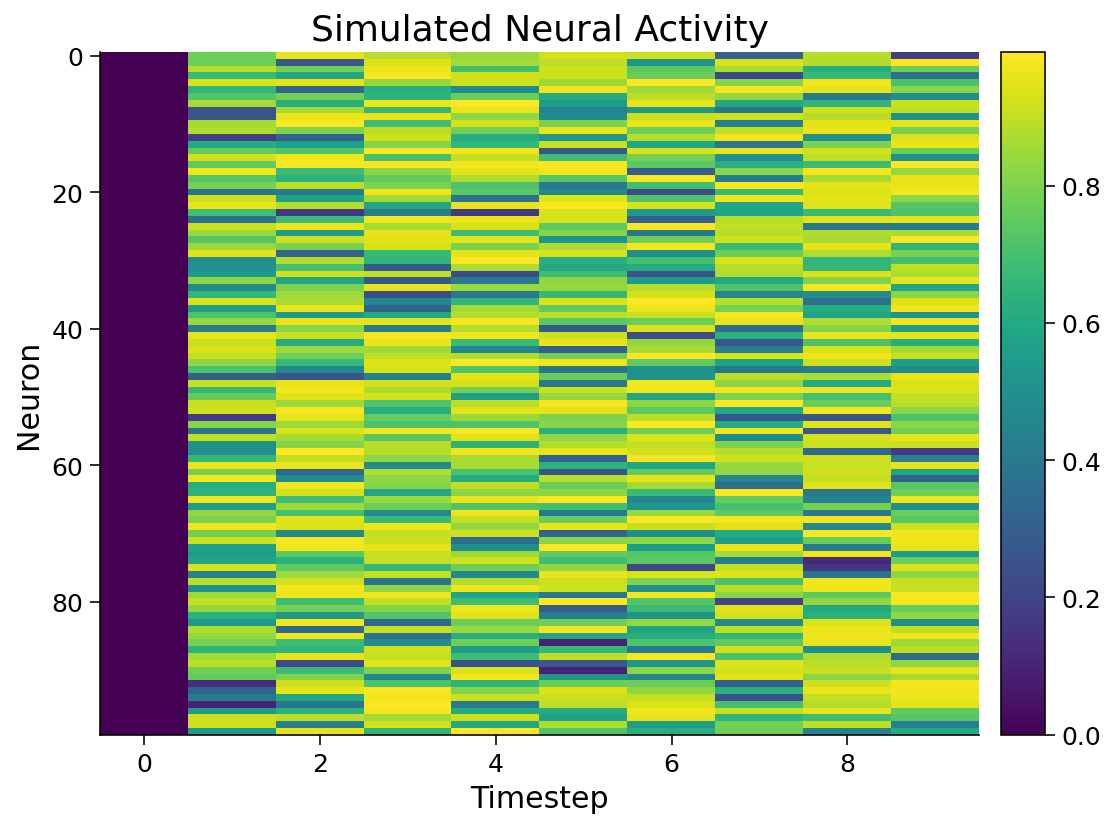

In [13]:
def simulate_neurons_iv(n_neurons, timesteps, eta, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        eta (float): the strength of the instrument
        random_state (int): seed for reproducibility

    Returns:
        The tuple (A,X,Z) of the connectivity matrix, simulated system, and instruments.
        - A has shape (n_neurons, n_neurons)
        - X has shape (n_neurons, timesteps)
        - Z has shape (n_neurons, timesteps)
    """
    np.random.seed(random_state)
    A = create_connectivity(n_neurons, random_state)

    X = np.zeros((n_neurons, timesteps))
    Z = np.random.choice([0, 1], size=(n_neurons, timesteps))
    for t in range(timesteps - 1):

      ############################################################################
      ## Insert your code here to adjust the update rule to include the
      ## instrumental variable.
      ##  We've already created Z for you. (We need to return it to regress on it).
      ##  Your task is to slice it appropriately. Don't forget eta.
      ## Fill out function and remove
      ## raise NotImplementedError('Complete simulate_neurons_iv function')
      ############################################################################

      IV_on_this_timestep = (eta * Z[:, t + 1])

      X[:, t + 1] = sigmoid(A.dot(X[:, t]) + IV_on_this_timestep + np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons)))

    return A, X, Z


# Set parameters
timesteps = 5000  # Simulate for 5000 timesteps.
n_neurons = 100  # the size of our system
eta = 2  # the strength of our instrument, higher is stronger

# Simulate our dynamical system for the given amount of time
A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta)

# Visualize
plot_neural_activity(X)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial4_Solution_69480bae.py)

*Example output:*

<img alt='Solution hint' align='left' width=1116.0 height=828.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D5_NetworkCausality/static/W3D5_Tutorial4_Solution_69480bae_0.png>



## Section 2.2: Estimate IV for simulated neural system

Since you just implemented two-stage least squares, we've provided the network implementation for you, with the function `get_iv_estimate_network()`. Now, let's see how our IV estimates do in recovering the connectivity matrix.

In [14]:
def get_iv_estimate_network(X, Z):
    """
    Estimates the connectivity matrix from 2-stage least squares regression
    using an instrument.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        Z (np.ndarray): our observed instruments of shape (n_neurons, timesteps)

    Returns:

        V (np.ndarray): the estimated connectivity matrix
    """
    n_neurons = X.shape[0]
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # Stage 1: regress X on Z
    stage1 = MultiOutputRegressor(LinearRegression(fit_intercept=True), n_jobs=-1)
    stage1.fit(Z[:, :-1].transpose(), X[:, :-1].transpose())
    X_hat = stage1.predict(Z[:, :-1].transpose())

    # Stage 2: regress Y on X_hatI
    stage2 = MultiOutputRegressor(LinearRegression(fit_intercept=True), n_jobs=-1)
    stage2.fit(X_hat, Y)

    # Get estimated effects
    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(stage2.estimators_):
        V[i, :] = estimator.coef_

    return V

Now let's see how well it works in our system.

IV estimated correlation: 0.916


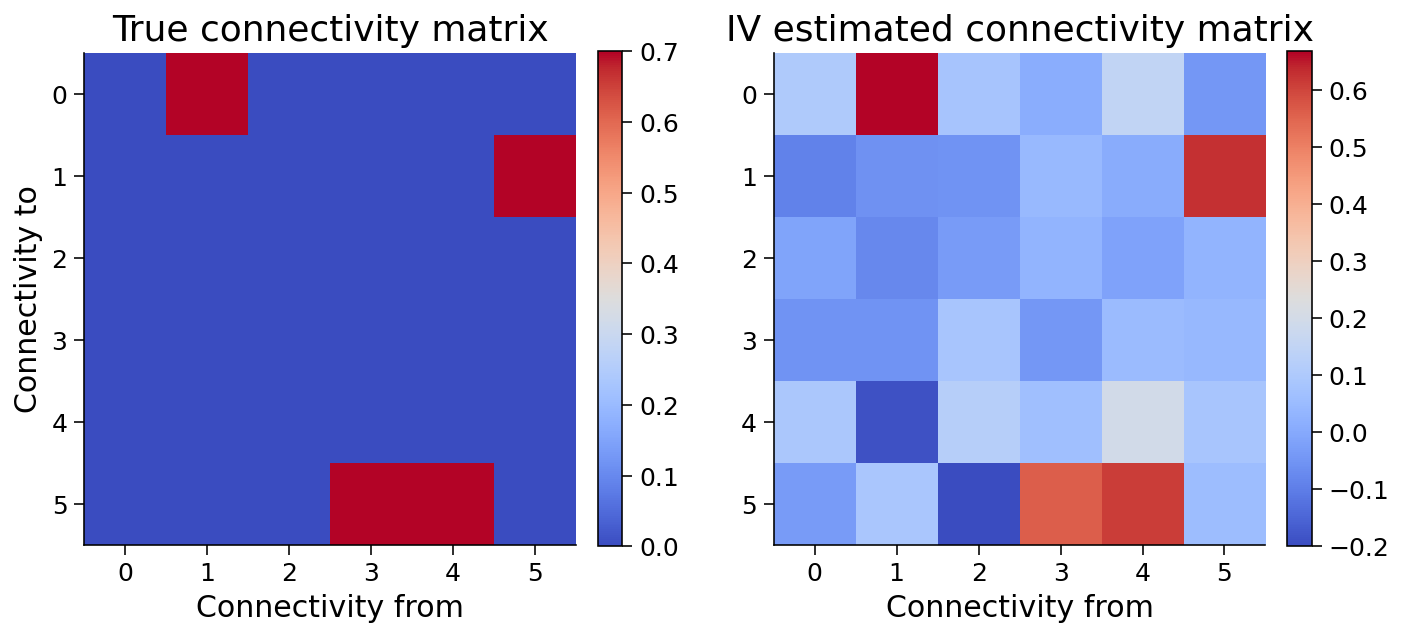

In [15]:
#@markdown Execute this cell to visualize IV estimated connectivity matrix
n_neurons = 6
timesteps = 10000
random_state = 42
eta = 2

A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)
V = get_iv_estimate_network(X, Z)
print("IV estimated correlation: {:.3f}".format(np.corrcoef(A.flatten(), V.flatten())[1, 0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = axs[0].imshow(A, cmap="coolwarm")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
axs[0].title.set_text("True connectivity matrix")
axs[0].set(xlabel='Connectivity from', ylabel='Connectivity to')

im = axs[1].imshow(V, cmap="coolwarm")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
axs[1].title.set_text("IV estimated connectivity matrix")
axs[1].set(xlabel='Connectivity from')

plt.show()

The IV estimates seem to perform pretty well! In the next section, we will see how they behave in the face of omitted variable bias.

---
# Section 3: IVs and omitted variable bias

*Estimated timing to here from start of tutorial: 40 min*


In [ ]:
# @title Video 5: IV vs regression
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1pv411q7Hc", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="zceWyoQn09s", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Interactive Demo 3: Estimating connectivity with IV vs regression on a subset of observed neurons

Change the ratio of observed neurons and look at the impact on the quality of connectivity estimation using IV vs regression. Which method does better with fewer observed neurons?



In [16]:
# @markdown Execute this cell to enable demo. This simulation will take about a minute to run!
n_neurons = 30
timesteps = 20000
random_state = 42
eta = 2
A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)


reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact
def plot_observed(ratio=[0.2, 0.4, 0.6, 0.8, 1.0]):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = int(ratio * n_neurons)
  n_observed = sel_idx
  offset = np.zeros((n_neurons, n_neurons))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[0].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  axs[0].title.set_text("True connectivity")
  axs[0].set_xlabel("Connectivity to")
  axs[0].set_ylabel("Connectivity from")
  plt.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)

  sel_A = A[:sel_idx, :sel_idx]
  sel_X = X[:sel_idx, :]
  sel_Z = Z[:sel_idx, :]

  V = get_iv_estimate_network(sel_X, sel_Z)
  iv_corr = np.corrcoef(sel_A.flatten(), V.flatten())[1, 0]

  big_V = np.zeros(A.shape)
  big_V[:sel_idx, :sel_idx] =  1 + V

  im = axs[1].imshow(big_V, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
  c = 'w' if n_observed < (n_neurons - 3) else 'k'
  axs[1].text(0,n_observed + 2, "Correlation : {:.2f}".format(iv_corr), color=c, size=15)
  axs[1].axis("off")


  reg_corr, R = get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)


  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R

  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[1].title.set_text("Estimated connectivity (IV)")
  axs[1].set_xlabel("Connectivity to")
  axs[1].set_ylabel("Connectivity from")

  axs[2].text(0, n_observed + 2,"Correlation : {:.2f}".format(reg_corr), color=c, size=15)
  axs[2].axis("off")
  axs[2].title.set_text("Estimated connectivity (regression)")
  axs[2].set_xlabel("Connectivity to")
  axs[2].set_ylabel("Connectivity from")

interactive(children=(Dropdown(description='ratio', options=(0.2, 0.4, 0.6, 0.8, 1.0), value=0.2), Output()), …

We can also visualize the performance of regression and IV as a function of the observed neuron ratio below.

**Note** that this code takes about a minute to run!

1
0.8
0.6
0.4
0.2


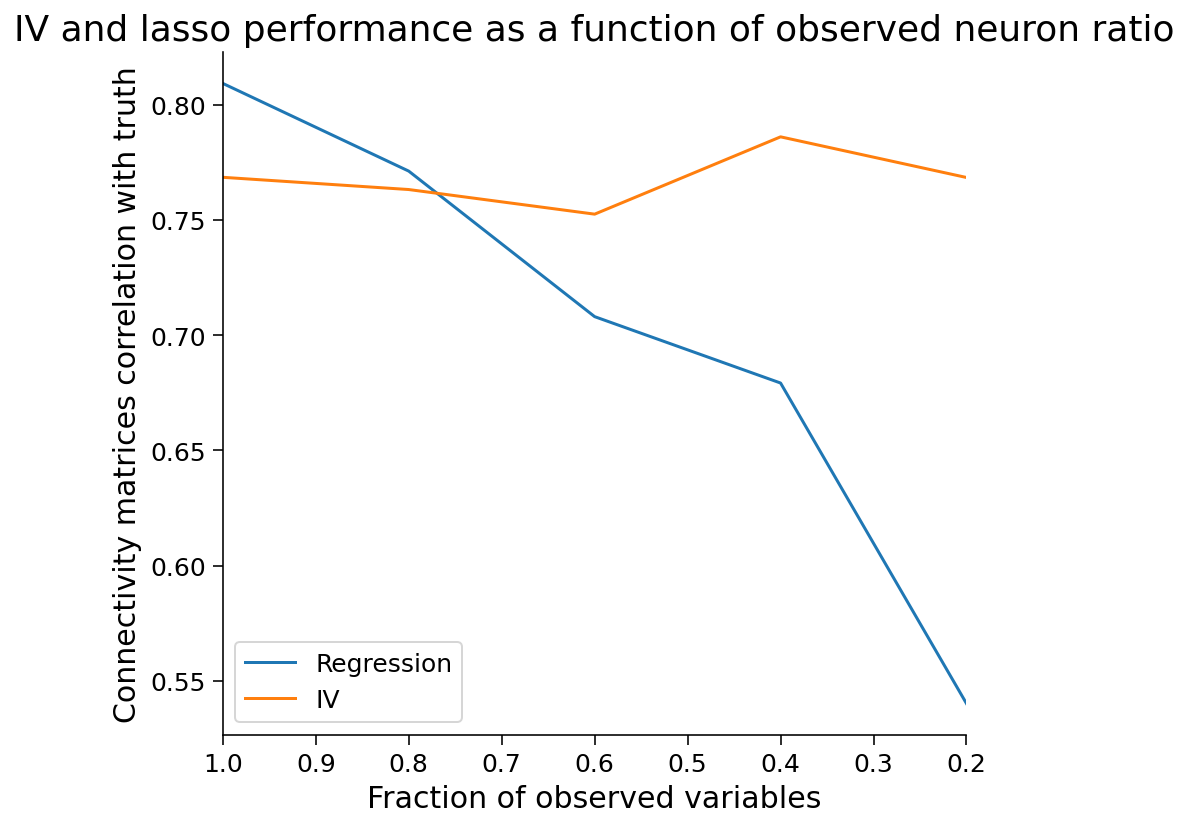

In [18]:
# @markdown Execute this cell to visualize connectivity estimation performance
def compare_iv_estimate_to_regression(observed_ratio):
  """
  A wrapper function to compare IV and Regressor performance as a function of observed neurons

  Args:
        observed_ratio(list): a list of different observed ratios (out of the whole system)
  """

  #Let's compare IV estimates to our regression estimates, uncomment the code below

  reg_corrs = np.zeros((len(observed_ratio),))
  iv_corrs = np.zeros((len(observed_ratio),))
  for j, ratio in enumerate(observed_ratio):
      print(ratio)
      sel_idx = int(ratio * n_neurons)

      sel_X = X[:sel_idx, :]
      sel_Z = X[:sel_idx, :]
      sel_A = A[:sel_idx, :sel_idx]

      sel_reg_V = get_regression_estimate(sel_X)
      reg_corrs[j] = np.corrcoef(sel_A.flatten(), sel_reg_V.flatten())[1, 0]

      sel_iv_V = get_iv_estimate_network(sel_X, sel_Z)
      iv_corrs[j] = np.corrcoef(sel_A.flatten(), sel_iv_V.flatten())[1, 0]

  # Plotting IV vs lasso performance
  plt.plot(observed_ratio, reg_corrs)
  plt.plot(observed_ratio, iv_corrs)
  plt.xlim([1, 0.2])
  plt.ylabel("Connectivity matrices correlation with truth")
  plt.xlabel("Fraction of observed variables")
  plt.title("IV and lasso performance as a function of observed neuron ratio")
  plt.legend(['Regression', 'IV'])

n_neurons = 40  # the size of the system
timesteps = 20000
random_state = 42
eta = 2  # the strength of our instrument

A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, random_state)

observed_ratio = [1, 0.8, 0.6, 0.4, 0.2]

compare_iv_estimate_to_regression(observed_ratio)

We see that IVs handle omitted variable bias (when the instrument is strong and we have enough data).

**The costs of IV analysis**

- we need to find an appropriate and valid instrument
- Because of the 2-stage estimation process, we need strong instruments or else our standard errors will be large

---
# Section 4: Thinking about causality in your work

*Estimated timing to here from start of tutorial: 50 min*

## Think 4!: Discussion questions

Please discuss the following in groups for around 10 minutes.

*   Think back to your most recent work. Can you create a causal diagram of the fundamental question? Are there sources of bias (omitted variables or otherwise) that might be a threat to causal validity?
*   Can you think of any possibilities for instrumental variables? What sources of observed randomness could studies in your field leverage in identifying causal effects?




---
# Summary

*Estimated timing of tutorial: 1 hour, 5 min*


In [ ]:
# @title Video 6: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Gt4y1X76z", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="1qxW8CPW77U", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In this tutorial, we:

* Explored instrumental variables and how we can use them for causality estimates
* Compared IV estimates to regression estimates

---
# Bonus

---
## Bonus Section 1: Exploring Instrument Strength

### Bonus Exercise 1: Exploring instrument strength

Explore how the strength of the instrument $\eta$ affects the quality of estimates with instrumental variables. 



Trial 1 of 3
Trial 2 of 3
Trial 3 of 3


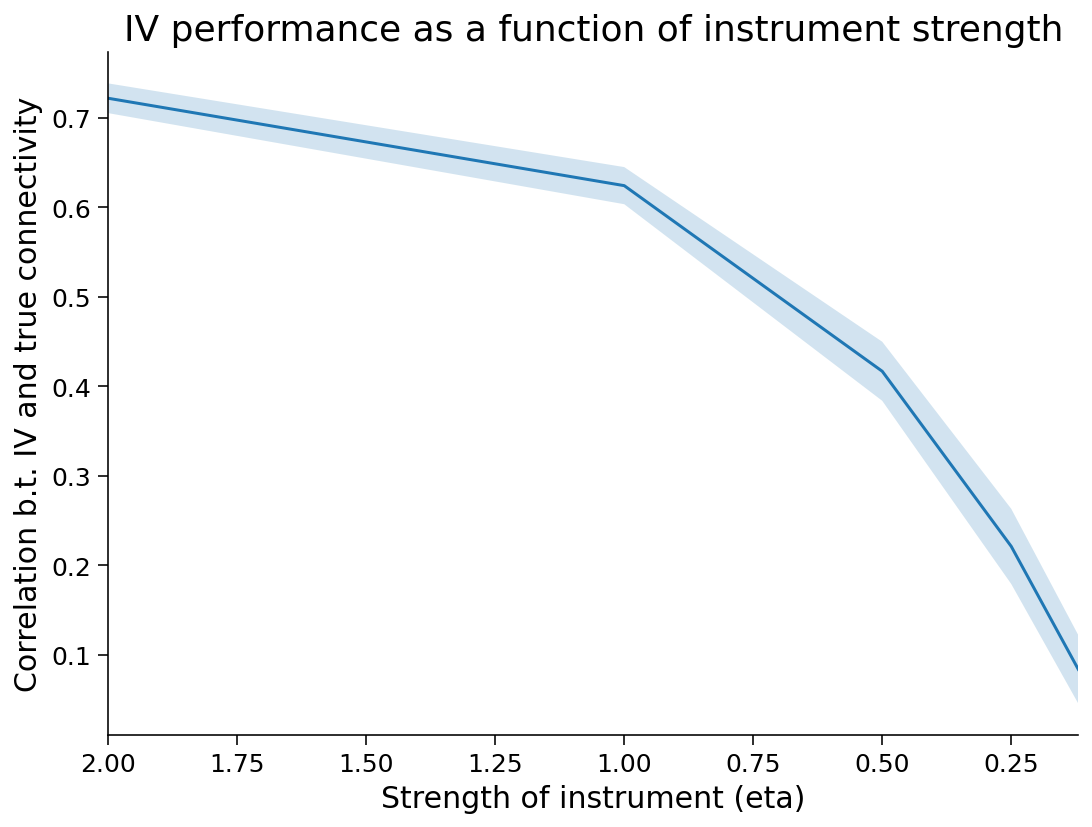

In [19]:
def instrument_strength_effect(etas, n_neurons, timesteps, n_trials):
  """ Compute IV estimation performance for different instrument strengths

  Args:
    etas (list): different instrument strengths to compare
    n_neurons (int): number of neurons in simulation
    timesteps (int): number of timesteps in simulation
    n_trials (int): number of trials to compute

  Returns:
    ndarray: n_trials x len(etas) array where each element is the correlation
        between true and estimated connectivity matries for that trial and
        instrument strength
  """

  # Initialize corr array
  corr_data = np.zeros((n_trials, len(etas)))

  # Loop over trials
  for trial in range(n_trials):
      print("Trial {} of {}".format(trial + 1, n_trials))

      # Loop over instrument strenghs
      for j, eta in enumerate(etas):
          ########################################################################
          ## TODO: Simulate system with a given instrument strength, get IV estimate,
          ## and compute correlation
          # Fill out function and remove
          ## raise NotImplementedError('Student exercise: complete instrument_strength_effect')
          ########################################################################

          # Simulate system
          A, X, Z = simulate_neurons_iv(n_neurons, timesteps, eta, trial)

          # Compute IV estimate
          iv_V = get_iv_estimate_network(X, Z)

          # Compute correlation
          corr_data[trial, j] =  np.corrcoef(A.flatten(), iv_V.flatten())[1, 0]

  return corr_data


# Parameters of system
n_neurons = 20
timesteps = 10000
n_trials = 3
etas = [2, 1, 0.5, 0.25, 0.12]  # instrument strengths to search over

# Get IV estimate performances
corr_data = instrument_strength_effect(etas, n_neurons, timesteps, n_trials)

# Visualize
plot_performance_vs_eta(etas, corr_data)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial4_Solution_288c9208.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D5_NetworkCausality/static/W3D5_Tutorial4_Solution_288c9208_3.png>



---
## Bonus Section 2: Granger Causality

Another potential solution to temporal causation that we might consider: [*Granger Causality*](https://en.wikipedia.org/wiki/Granger_causality).

But, like the simultaneous fitting we explored in Tutorial 3, this method still fails in the presence of unobserved variables.

We are testing whether a time series $X$ Granger-causes a time series $Y$ through a hypothesis test:

- the null hypothesis $H_0$: lagged values of $X$ do not help predict values of $Y$ 

- the alternative hypothesis $H_a$: lagged values of $X$ **do** help predict values of $Y$ 

Mechanically, this is accomplished by fitting autoregressive models for $y_{t}$. We fail to reject the hypothesis if none of the $x_{t-k}$ terms are retained as significant in the regression. For simplicity, we will consider only one time lag. So, we have:

$$
H_0: y_t = a_0 + a_1 y_{t-1} +\epsilon_t
$$

$$
H_a: y_t = a_0 + a_1 y_{t-1} + b_1 x_{t-1} +\epsilon_t
$$

In [20]:
#@markdown Execute this cell to get custom imports from stats models
# we need custom imports from stats models
!pip install statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Bonus Section 2.1: Granger causality in small systems

We will first evaluate Granger causality in a small system.



#### Bonus Coding Exercise 2.1: Evaluate Granger causality

Complete the following definition to evaluate the Granger causality between our neurons. Then run the cells below to evaluate how well it works. You will use the `grangercausalitytests()` function already imported from statsmodels. We will then check whether a neuron in a small system Granger-causes the others.


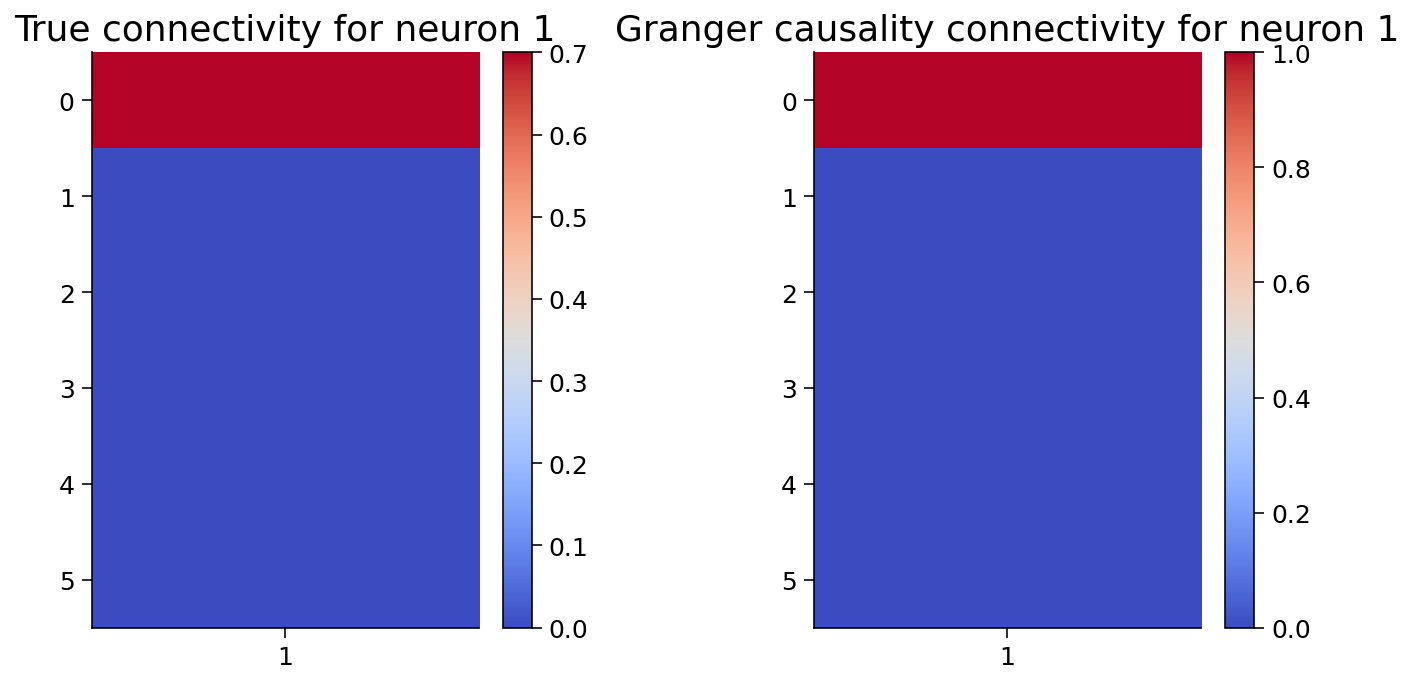

In [21]:
def get_granger_causality(X, selected_neuron, alpha=0.05):
    """
    Estimates the lag-1 granger causality of the given neuron on the other neurons in the system.

    Args:
        X (np.ndarray): the matrix holding our dynamical system of shape (n_neurons, timesteps)
        selected_neuron (int): the index of the neuron we want to estimate granger causality for
        alpha (float): Bonferroni multiple comparisons correction

    Returns:
        A tuple (reject_null, p_vals)
        reject_null (list): a binary list of length n_neurons whether the null was
            rejected for the selected neuron granger causing the other neurons
        p_vals (list): a list of the p-values for the corresponding Granger causality tests
    """
    n_neurons = X.shape[0]
    max_lag = 1

    reject_null = []
    p_vals = []

    for target_neuron in range(n_neurons):
        ts_data = X[[target_neuron, selected_neuron], :].transpose()

        ########################################################################
        ## Insert your code here to run Granger causality tests.
        ##
        ## Function Hints:
        ##     Pass the ts_data defined above as the first argument
        ##     Granger causality -> grangercausalitytests
        ## Fill out this function and then remove
        ## raise NotImplementedError('Student exercise: complete get_granger_causality function')
        ########################################################################
        res = grangercausalitytests(ts_data, maxlag=max_lag, verbose=False)

        # Gets the p-value for the log-ratio test
        pval = res[1][0]['lrtest'][1]

        p_vals.append(pval)
        reject_null.append(int(pval < alpha))

    return reject_null, p_vals


# Set up small system
n_neurons = 6
timesteps = 5000
random_state = 42
selected_neuron = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

# Estimate Granger causality
reject_null, p_vals = get_granger_causality(X, selected_neuron)

# Visualize
compare_granger_connectivity(A, reject_null, selected_neuron)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial4_Solution_d093bee3.py)

*Example output:*

<img alt='Solution hint' align='left' width=1387.0 height=683.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D5_NetworkCausality/static/W3D5_Tutorial4_Solution_d093bee3_0.png>



Looks good! Let's also check the correlation between Granger estimates and the true connectivity.


In [22]:
np.corrcoef(A[:,selected_neuron], np.array(reject_null))[1, 0]

1.0

When we have a small system, we correctly identify the causality of neuron 1.

### Bonus Section 2.2: Granger causality in large systems

We will now run Granger causality on a large system with 100 neurons. Does it still work well? How does the number of timesteps matter?

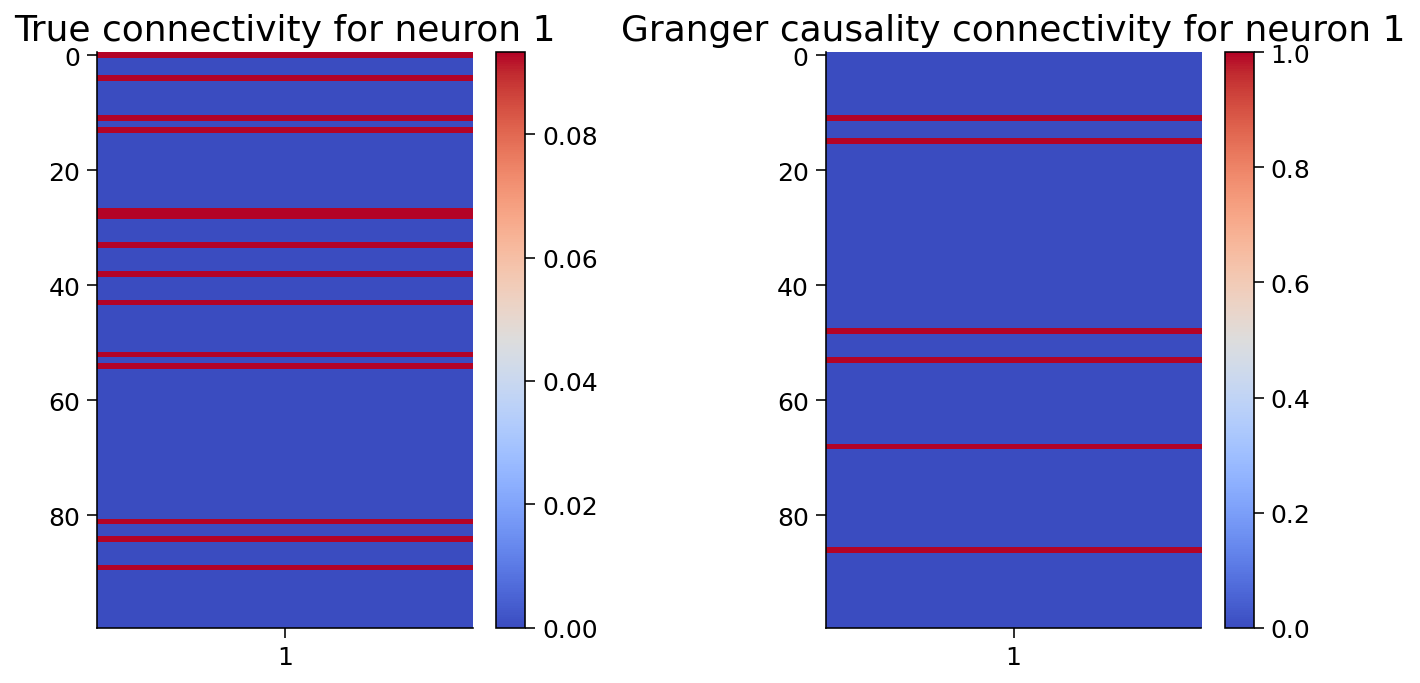

In [23]:
#@markdown Execute this cell to examine Granger causality in a large system
n_neurons = 100
timesteps = 5000
random_state = 42
selected_neuron = 1
A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

# get granger causality estimates
reject_null, p_vals = get_granger_causality(X, selected_neuron)
compare_granger_connectivity(A, reject_null, selected_neuron)

Let's again check the correlation between the Granger estimates and the true connectivity. Are we able to recover the true connectivity well in this larger system?

In [24]:
np.corrcoef(A[:,selected_neuron], np.array(reject_null))[1, 0]

0.019416331902158267

**Notes on Granger Causality**

Here we considered bivariate Granger causality -- for each pair of neurons $A, B$, does one Granger-cause the other? You might wonder whether considering more variables will help with estimation. *Conditional Granger Causality* is a technique that allows for a multivariate system, where we test whether $A$ Granger-causes $B$ conditional on the other variables in the system. 

Even after controlling for variables in the system, conditional Granger causality will also likely perform poorly as our system gets larger. Plus, measuring the additional variables to condition on may be infeasible in practical applications, which would introduce omitted variable bias as we saw in the regression exercise.

One takeaway here is that as our estimation procedures become more sophisticated, they also become more difficult to interpret. We always need to understand the methods and the assumptions that are made.